In [2]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister

In [3]:
iris = datasets.load_iris()

In [4]:
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,test_size=0.33,random_state=42)

## Quantum Circuits

4 Qubits => 4 features <br>
N = 4 (qO0, qO1, qO2, qO3) <br>
1 classical Register cO (classical output)

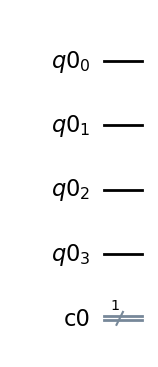

In [5]:
N=4
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

qc.draw("mpl")

## Rotating Qubits About The Angles

This rotates the qubits and then encodes those classical numbers onto the qubits (this can be done more complicated ways) <br>
Rotating the qubits is really just the simplest way of getting the data onto the quantum processor

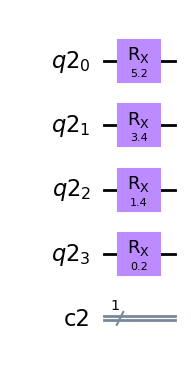

In [7]:
N=4
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for i, x in enumerate(X_train[0]):
    qc.rx(x, i)

qc.draw("mpl")

## Feature Map

In [8]:
N=4
def feature_map(X):

    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    for i, x in enumerate(X):
        qc.rx(x, i)
    return qc, c 

We need to get measure quantum circuit, we need to get output <br>
This measurement is going to be our prediction of the quantum circuit

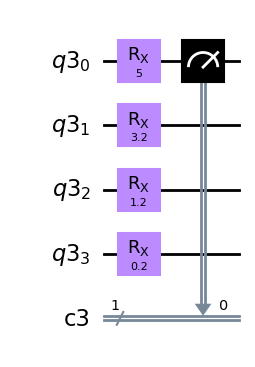

In [9]:
qc, c =feature_map(X_train[5])


# measurement operator
qc.measure(0,c)

qc.draw("mpl")

The output can be either 0 or 1 <br>
I want to introduce variational circuit, <br>
I want to introduce more rotations that we are getting gonna be learning

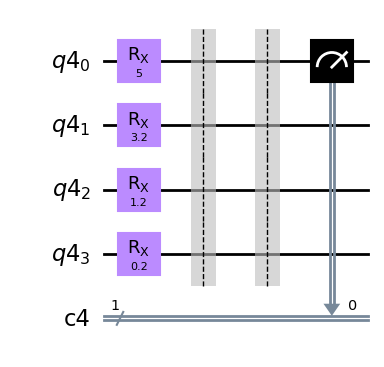

In [10]:
qc, c =feature_map(X_train[5])

qc.barrier()

qc.barrier()

# measurement operator
qc.measure(0,c)

qc.draw("mpl")

In between those gray lines ı want to put some more rotations. <br>
These rotations will have angles that we want to learn, we want to optimize those angles such that the quantum circuit then predict the right label (0 or 1 ).

## Variational Circuits

In [11]:
def variational_circuit(qc, theta):
      for i in range(N-1):
            qc.cnot(i,i+1)
      qc.cnot(N-1, 0)
      for i in range(N):
            qc.ry(theta[i], i)
      return qc

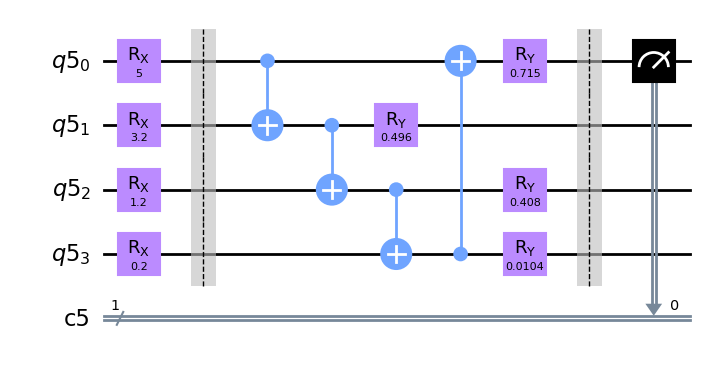

In [12]:
import numpy as np
qc, c =feature_map(X_train[5])

qc.barrier()

qc = variational_circuit(qc, np.random.rand(N))

qc.barrier()

# measurement operator
qc.measure(0,c)

qc.draw("mpl")

Variational circuits contains rotations. <br>
I have put just random angles for illustration <br>
The goal is now that we want to learn those angles we want to learn optimal angles such that our quantum circuit outputs us right class <br>
Blue line are c not gates. they create entanglement, so they essentially allow information to travel from one qubit to another <br>
I am measuring here the zeroth cubit (for output)

{'1': 6062, '0': 3938}
0.6062


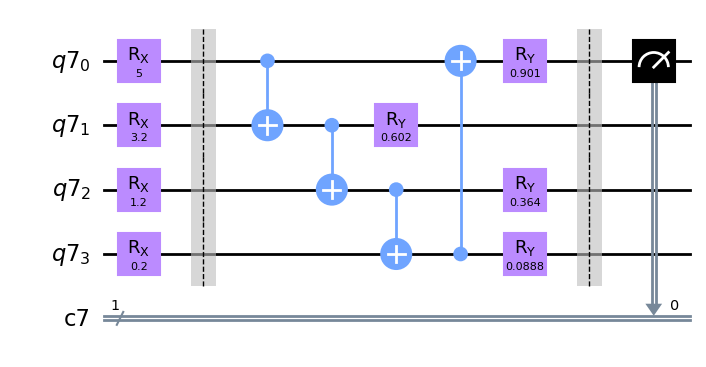

In [14]:
import qiskit 

qc, c =feature_map(X_train[5])

qc.barrier()

qc = variational_circuit(qc, np.random.rand(N))

qc.barrier()

# measurement operator
qc.measure(0,c)

shots = 1E4
backend = Aer.get_backend("qasm_simulator")
job = qiskit.execute(qc, backend, shots=shots)
result = job.result()
counts = result.get_counts(qc)
print(counts)
print(counts["1"]/shots)


qc.draw("mpl")

Run quantum circuits 10000 times, ı have run it on quantum simulator "qasm_simulator" which simulates the quantum computer without any errors <br>
The prediction of this quantum circuit is 1 <br>
But real => 0

## Quantum Neural Network Function

In [15]:
def quantum_nn(X, theta, simulator=True):

    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0,c)

    shots = 1E4
    backend = Aer.get_backend("qasm_simulator")
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts["1"]/shots

In [16]:
prediction = quantum_nn(X_train[5], np.random.rand(N))
prediction

0.6298

In [17]:
target = Y_train[5]
target

0

In [19]:
def loss(prediction, target):
      return (target - prediction)**2

In [20]:
loss(prediction, target)

0.39664804000000004

## Stochastic Gradient Descent

We want to minimize this loss function to do that; <br>
We need to loop over our training data then, <br>
We need to update our variational parameters <br>
We're gonna loop through our training data and <br>
For every training data example, we're gonna get the prediction of our quantum neural network <br>
We will then plug this into our loss function which tells us how far our prediction is away from the true value <br>
And then , we're gonna be using this information to update the theta (our variational parameters in the variational circuits) <br>
The gradient is essentially just taking the derivative of the loss function with respect to every entry in this theta vector here. <br>
Eta is called learning rate <br>
Eta is called hyper parameter

In [21]:
import copy

def gradient(X, Y, theta):
    
      delta = 0.01

      grad = []
    
      for i in range(len(theta)):

          dtheta = copy.copy(theta)
          dtheta[i] += delta

          pred1 = quantum_nn(X, dtheta)
          pred2 = quantum_nn(X, theta)
          # finite difference
          grad.append( (loss(pred1, Y)-loss(pred2, Y))/ delta)

      return np.array(grad)

The way ı am calculating a derivative is using finite difference <br>
Finite difference: you just evaluate loss function for dtheta, then you substruct the loss function evaluated at theta and divide by small value (delta) <br>
We are doing for every theta value and return gradient vector

In [22]:
def accuracy(X, Y, theta):

      counter = 0
      for X_i, Y_i in zip(X, Y):

          prediction = quantum_nn(X_i, theta)

          if prediction < 0.5 and Y_i == 0:
               counter +=1
          elif prediction >= 0.5 and Y_i == 1:
               counter +=1
      return counter/len(Y)

In [23]:
eta = 0.05 

loss_list = []
theta = np.ones(N)

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(20):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))

        # update theta,gradient descent rule
        theta = theta - eta * gradient(X_i, Y_i, theta)
    
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.287 	 0.194
1 	 0.282 	 0.179
2 	 0.284 	 0.134
3 	 0.288 	 0.209
4 	 0.285 	 0.149
5 	 0.290 	 0.194
6 	 0.313 	 0.149
7 	 0.314 	 0.149
8 	 0.312 	 0.149
9 	 0.313 	 0.179
10 	 0.308 	 0.179
11 	 0.290 	 0.209
12 	 0.266 	 0.746
13 	 0.238 	 0.806
14 	 0.236 	 0.687
15 	 0.247 	 0.776
16 	 0.236 	 0.776
17 	 0.233 	 0.806
18 	 0.230 	 0.851
19 	 0.231 	 0.821


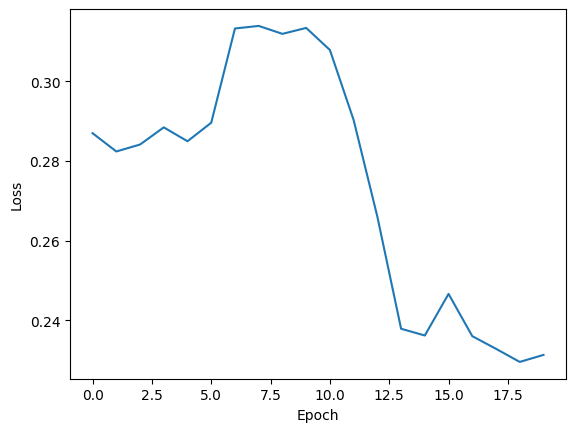

In [24]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Accuracy On Test Set

In [25]:
accuracy(X_test, Y_test, theta)

0.696969696969697

## How To Improve Accuracy?

We could improve that by training in a bit longer <br>
We could also have better loss function, variational circuits <br>
We could also do some normalization on the input data

## Classical ML Model (SVM)

In [27]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Create an instance of the SVM classifier
clf = svm.SVC()

# Fit the classifier to the training data
clf.fit(X_train, Y_train)

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate the accuracy by comparing predicted labels to the true labels
accuracy = accuracy_score(Y_test, predictions)

# Print the predicted labels, true labels, and accuracy
print("Predicted labels:", predictions)
print("True labels:", Y_test)
print("Accuracy:", accuracy)


Predicted labels: [1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1]
True labels: [1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1]
Accuracy: 1.0
